In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import os
from torch.utils.data import random_split, Dataset, DataLoader, Subset, SubsetRandomSampler
import torch.nn as nn
from torchvision import models
import timm 
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
from collections import defaultdict
import random
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
from collections import Counter

def print_class_distribution(dataset, class_names):
    labels = [dataset[i][1] for i in range(len(dataset))]
    counts = Counter(labels)

    print(" Class distribution:")
    for cls_idx, count in sorted(counts.items(), key=lambda x: x[1]):
        print(f"{class_names[cls_idx]:<15} ({cls_idx}): {count} samples")


# Dataloader

In [5]:
# Classification dataset class
class ClassificationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

        self.image_paths = []
        self.labels = []

        for cls_name in self.classes:
            cls_folder = os.path.join(root_dir, cls_name)
            for img_name in os.listdir(cls_folder):
                img_path = os.path.join(cls_folder, img_name)
                self.image_paths.append(img_path)
                self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

# Instantiate full dataset
dataset_path = "/kaggle/input/skyview-an-aerial-landscape-dataset/Aerial_Landscapes"
dataset = ClassificationDataset(root_dir=dataset_path, transform=transform)
batch_size = 32
generator = torch.Generator().manual_seed(42)

# Baseline model - using predefined balanced split
split_path = "/kaggle/input/comp9517dataset"
train_idx = np.load(f"{split_path}/train_indices.npy")
val_idx = np.load(f"{split_path}/val_indices.npy")

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader_bal = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)  # Shared validation set

# Imbalanced model - construct long-tail subset
def make_imbalanced_dataset(dataset, class_counts):
    class_to_indices = defaultdict(list)
    for idx, (_, label) in enumerate(dataset):
        class_to_indices[label].append(idx)

    selected_indices = []
    for cls, count in class_counts.items():
        indices = class_to_indices[cls]
        random.shuffle(indices)
        selected_indices.extend(indices[:count])

    return Subset(dataset, selected_indices)

class_counts = {i: max(50, 800 - i * 50) for i in range(15)}
imbalanced_subset = make_imbalanced_dataset(dataset, class_counts)

# Only split the training portion (validation set remains the same)
train_size = int(0.8 * len(imbalanced_subset))
train_dataset_imb, _ = torch.utils.data.random_split(
    imbalanced_subset,
    [train_size, len(imbalanced_subset) - train_size],
    generator=generator
)

train_loader_imb = DataLoader(train_dataset_imb, batch_size=batch_size, shuffle=True)
print_class_distribution(train_dataset_imb, dataset.classes)

# Print dataset sizes
print("Balanced training set size:", len(train_idx))
print("Imbalanced training set size:", len(train_dataset_imb))
print("Shared validation set size:", len(val_idx))

 Class distribution:
River           (14): 77 samples
Residential     (13): 111 samples
Railway         (12): 157 samples
Port            (11): 191 samples
Parking         (10): 240 samples
Mountain        (9): 288 samples
Lake            (8): 326 samples
Highway         (7): 357 samples
Grassland       (6): 388 samples
Forest          (5): 448 samples
Desert          (4): 476 samples
City            (3): 521 samples
Beach           (2): 549 samples
Airport         (1): 624 samples
Agriculture     (0): 647 samples
Balanced training set size: 9600
Imbalanced training set size: 5400
Shared validation set size: 2400


# Model

In [6]:
def get_model(num_classes: int, pretrained=True):
    model = models.resnet18(pretrained=pretrained)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


# class weights, use for imbalance

In [7]:
def get_class_weights(dataset, num_classes):
    labels = [dataset[i][1] for i in range(len(dataset))]
    weights = compute_class_weight('balanced', classes=np.arange(num_classes), y=labels)
    return torch.tensor(weights, dtype=torch.float)

# train

In [11]:
def train(model, dataloader, criterion, optimizer, device, epoch=None, verbose=True):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    if verbose:
        if epoch is not None:
            print(f"Epoch {epoch}: Train Loss = {epoch_loss:.4f}, Acc = {epoch_acc:.4f}")
        else:
            print(f"Train Loss = {epoch_loss:.4f}, Acc = {epoch_acc:.4f}")

    return epoch_loss, epoch_acc


# validate

In [12]:
def validate(model, dataloader, criterion, device, epoch=None, verbose=True):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    if verbose:
        if epoch is not None:
            print(f"Epoch {epoch}: Val Loss = {epoch_loss:.4f}, Acc = {epoch_acc:.4f}")
        else:
            print(f"Val Loss = {epoch_loss:.4f}, Acc = {epoch_acc:.4f}")

    return epoch_loss, epoch_acc


# evaluate

In [13]:
def evaluate_metrics(y_true, y_pred, class_names=None, model_name=None):
    if model_name:
        print(f"\n Evaluation for: {model_name}")
    else:
        print("\n Classification Report:")

    print(classification_report(
        y_true, y_pred, 
        target_names=class_names, 
        digits=4, 
        zero_division=0
    ))

    macro_f1 = f1_score(y_true, y_pred, average='macro')
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')

    print(f" Macro F1-score:    {macro_f1:.4f}")
    print(f" Weighted F1-score: {weighted_f1:.4f}")

    return {
        "macro_f1": macro_f1,
        "weighted_f1": weighted_f1
    }


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 15
num_epochs = 12
results = {}
model_name = "resnet"
# maintain training data
train_losses_bal, val_losses_bal = [], []
train_accs_bal, val_accs_bal = [], []

train_losses_imb, val_losses_imb = [], []
train_accs_imb, val_accs_imb = [], []

# ========== Training A: Baseline ==========
print(f"\n Training {model_name.upper()} - Baseline (Balanced)")
model_bal = get_model(num_classes).to(device)
criterion_bal = nn.CrossEntropyLoss()
optimizer_bal = torch.optim.Adam(model_bal.parameters(), lr=1e-4)

for epoch in range(num_epochs):
    train_loss, train_acc = train(model_bal, train_loader_bal, criterion_bal, optimizer_bal, device, epoch)
    val_loss, val_acc = validate(model_bal, val_loader, criterion_bal, device, epoch)
    train_losses_bal.append(train_loss)
    val_losses_bal.append(val_loss)
    train_accs_bal.append(train_acc)
    val_accs_bal.append(val_acc)

# Collect baseline predictions
model_bal.eval()
all_preds_bal, all_labels_bal = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_bal(images)
        _, preds = torch.max(outputs, 1)
        all_preds_bal.extend(preds.cpu().numpy())
        all_labels_bal.extend(labels.cpu().numpy())

results["baseline"] = {
    'true': all_labels_bal,
    'pred': all_preds_bal
}

# ========== Training B: Imbalance + Class Weights ==========
print(f"\n Training {model_name.upper()} - Imbalance + Class Weight")
model_imb = get_model(num_classes).to(device)
class_weights = get_class_weights(train_dataset_imb, num_classes).to(device)
criterion_imb = nn.CrossEntropyLoss(weight=class_weights)
optimizer_imb = torch.optim.Adam(model_imb.parameters(), lr=1e-4)

for epoch in range(num_epochs):
    train_loss, train_acc = train(model_imb, train_loader_imb, criterion_imb, optimizer_imb, device, epoch)
    val_loss, val_acc = validate(model_imb, val_loader, criterion_imb, device, epoch)
    train_losses_imb.append(train_loss)
    val_losses_imb.append(val_loss)
    train_accs_imb.append(train_acc)
    val_accs_imb.append(val_acc)

# Collect imbalance predictions
model_imb.eval()
all_preds_imb, all_labels_imb = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_imb(images)
        _, preds = torch.max(outputs, 1)
        all_preds_imb.extend(preds.cpu().numpy())
        all_labels_imb.extend(labels.cpu().numpy())

results["imbalanced"] = {
    'true': all_labels_imb,
    'pred': all_preds_imb
}


 Training RESNET - Baseline (Balanced)
Epoch 0: Train Loss = 0.3987, Acc = 0.8874
Epoch 0: Val Loss = 0.1190, Acc = 0.9679
Epoch 1: Train Loss = 0.0894, Acc = 0.9750
Epoch 1: Val Loss = 0.1158, Acc = 0.9663
Epoch 2: Train Loss = 0.0451, Acc = 0.9889
Epoch 2: Val Loss = 0.1090, Acc = 0.9679
Epoch 3: Train Loss = 0.0346, Acc = 0.9897
Epoch 3: Val Loss = 0.1181, Acc = 0.9654
Epoch 4: Train Loss = 0.0305, Acc = 0.9924
Epoch 4: Val Loss = 0.0916, Acc = 0.9725
Epoch 5: Train Loss = 0.0260, Acc = 0.9931
Epoch 5: Val Loss = 0.1043, Acc = 0.9688
Epoch 6: Train Loss = 0.0259, Acc = 0.9928
Epoch 6: Val Loss = 0.1207, Acc = 0.9633
Epoch 7: Train Loss = 0.0197, Acc = 0.9947
Epoch 7: Val Loss = 0.1025, Acc = 0.9683
Epoch 8: Train Loss = 0.0115, Acc = 0.9979
Epoch 8: Val Loss = 0.0913, Acc = 0.9729
Epoch 9: Train Loss = 0.0178, Acc = 0.9953
Epoch 9: Val Loss = 0.1804, Acc = 0.9513
Epoch 10: Train Loss = 0.0308, Acc = 0.9898
Epoch 10: Val Loss = 0.1358, Acc = 0.9583
Epoch 11: Train Loss = 0.0216, Acc


 Evaluation for: Baseline
              precision    recall  f1-score   support

 Agriculture     0.9595    0.9708    0.9651       171
     Airport     0.9371    0.9430    0.9401       158
       Beach     0.9767    0.9941    0.9853       169
        City     0.9693    0.9518    0.9605       166
      Desert     0.9810    0.9810    0.9810       158
      Forest     0.9658    0.9860    0.9758       143
   Grassland     0.9693    0.9461    0.9576       167
     Highway     0.9487    0.9367    0.9427       158
        Lake     0.9608    0.9545    0.9577       154
    Mountain     0.9691    0.9691    0.9691       162
     Parking     0.9826    0.9883    0.9854       171
        Port     0.9935    0.9806    0.9870       155
     Railway     0.9281    0.9451    0.9366       164
 Residential     0.9797    0.9797    0.9797       148
       River     0.9226    0.9167    0.9196       156

    accuracy                         0.9629      2400
   macro avg     0.9629    0.9629    0.9629      2400

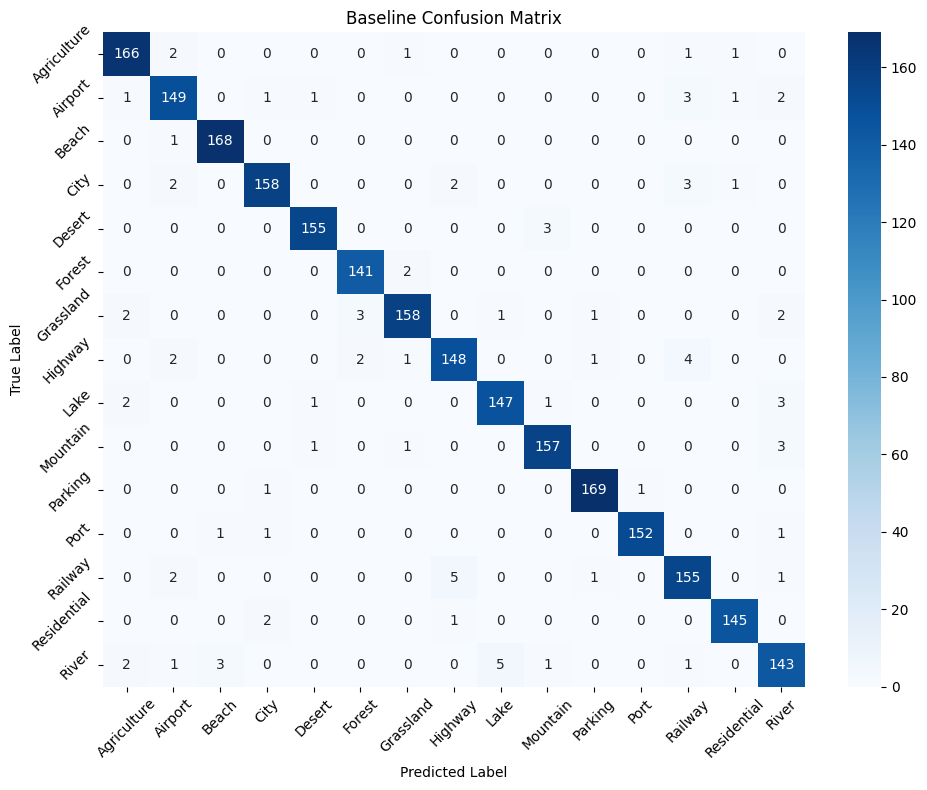

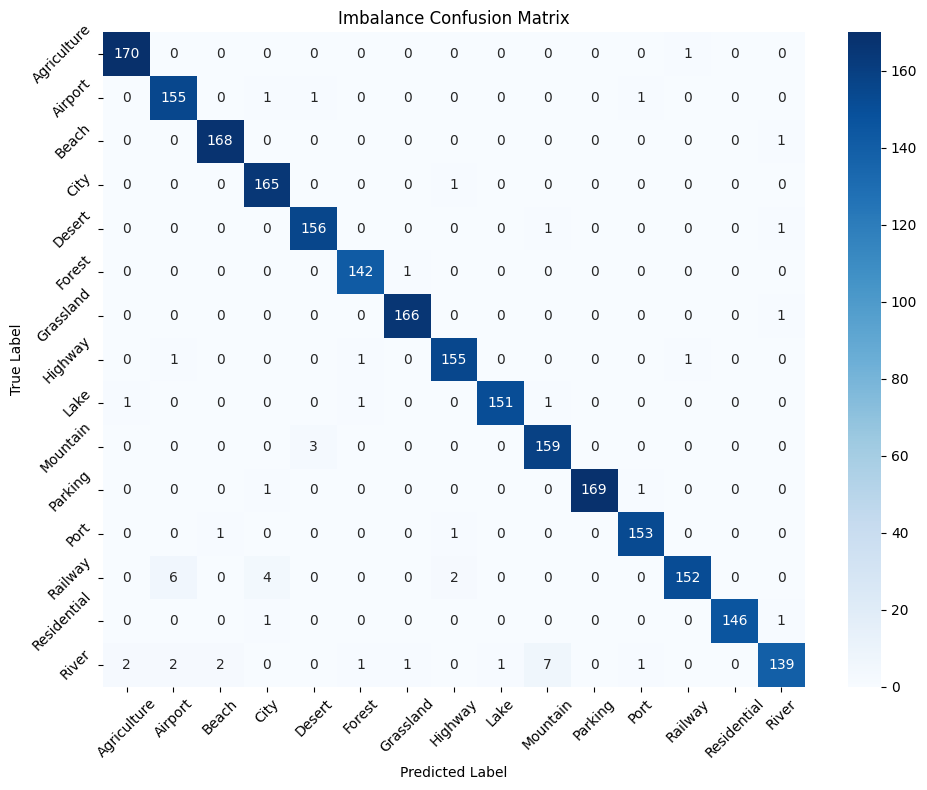

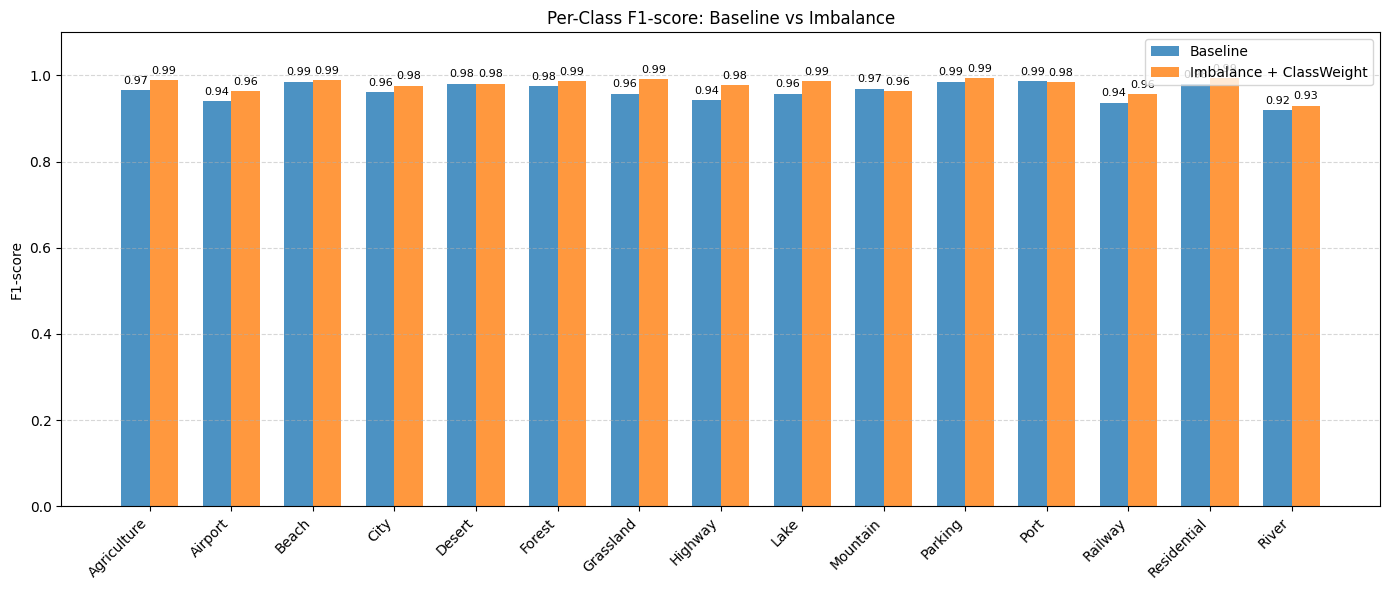

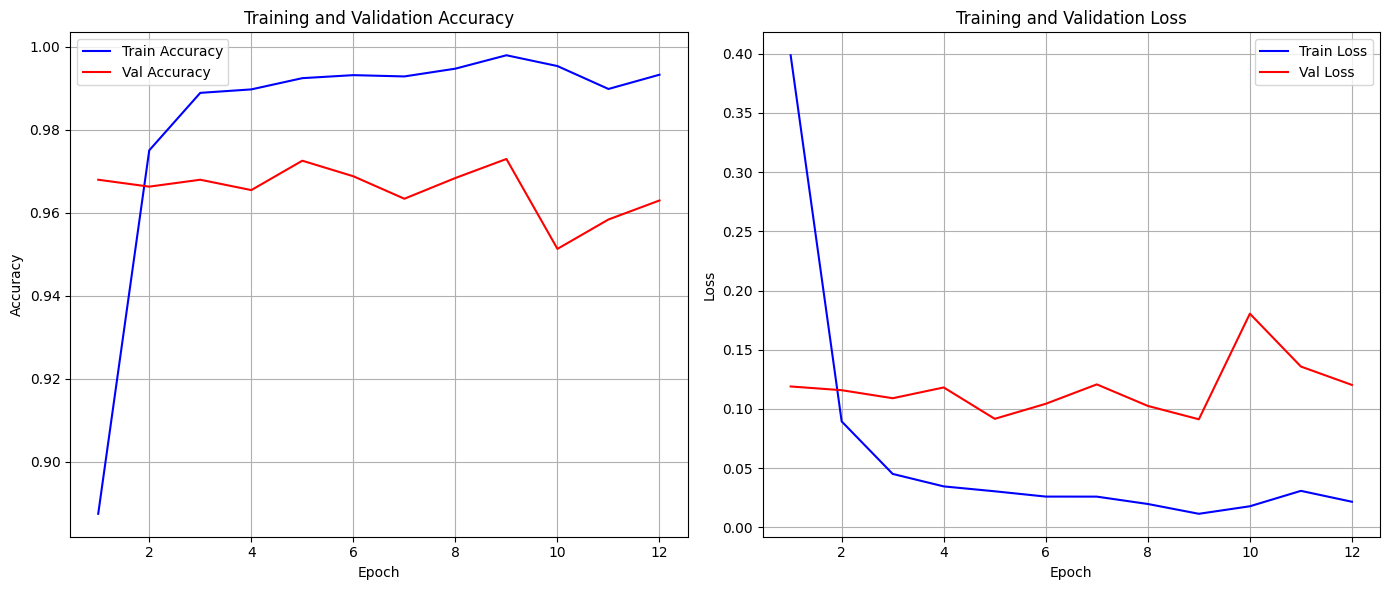

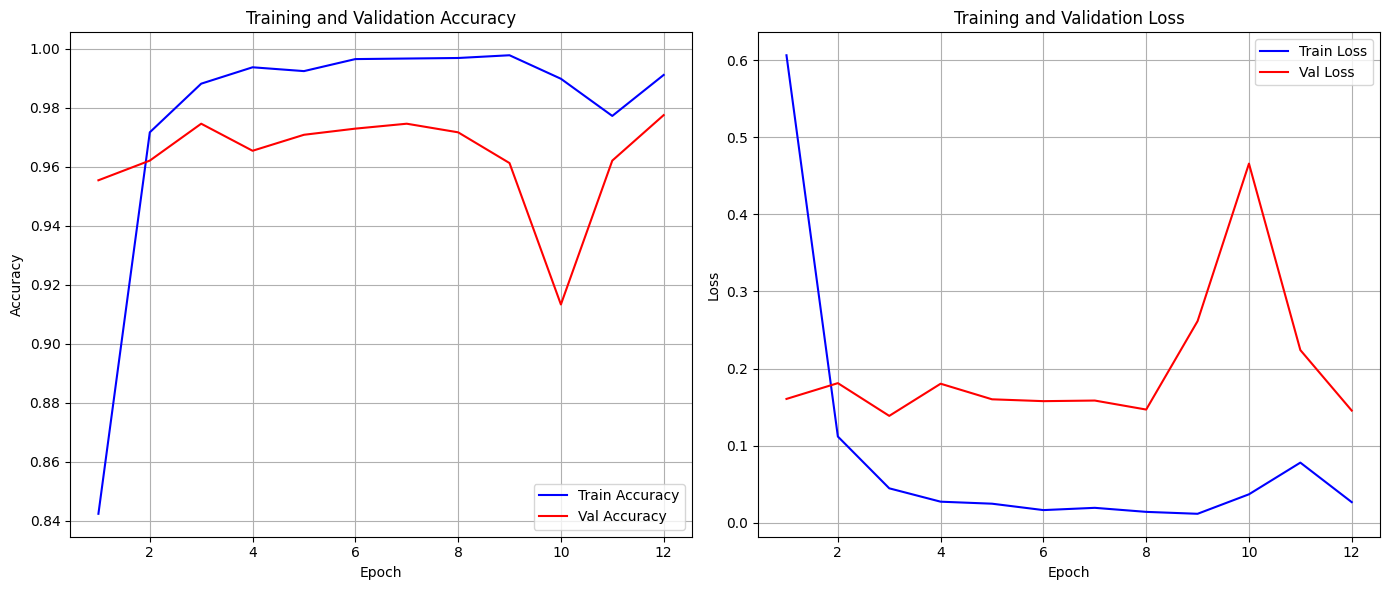

In [19]:

# plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix", save_path=None):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# plot f1 score comparison
def plot_f1_score_comparison(f1_bal, f1_imb, class_names, save_path=None):
    x = np.arange(len(class_names))
    width = 0.35

    plt.figure(figsize=(14, 6))
    bars1 = plt.bar(x - width/2, f1_bal, width, label='Baseline', alpha=0.8)
    bars2 = plt.bar(x + width/2, f1_imb, width, label='Imbalance + ClassWeight', alpha=0.8)

    for bar in bars1:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2f}", ha='center', va='bottom', fontsize=8)

    for bar in bars2:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2f}", ha='center', va='bottom', fontsize=8)

    plt.xticks(ticks=x, labels=class_names, rotation=45, ha='right')
    plt.ylabel('F1-score')
    plt.ylim(0, 1.1)
    plt.title('Per-Class F1-score: Baseline vs Imbalance')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# plot training curves
def plot_training_curves(train_accs, val_accs, train_losses, val_losses, title="Training Curves", save_path=None):
    epochs = range(1, len(train_accs) + 1)
    
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accs, 'b-', label='Train Accuracy')
    plt.plot(epochs, val_accs, 'r-', label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, val_losses, 'r-', label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

evaluate_metrics(all_labels_bal, all_preds_bal, class_names=dataset.classes, model_name="Baseline")
evaluate_metrics(all_labels_imb, all_preds_imb, class_names=dataset.classes, model_name="Imbalanced")

# 2. 混淆矩阵
plot_confusion_matrix(all_labels_bal, all_preds_bal, dataset.classes, title="Baseline Confusion Matrix", save_path="baseline_confusion_matrix.png")
plot_confusion_matrix(all_labels_imb, all_preds_imb, dataset.classes, title="Imbalance Confusion Matrix", save_path="imbalance_confusion_matrix.png")


f1_bal = f1_score(all_labels_bal, all_preds_bal, average=None)
f1_imb = f1_score(all_labels_imb, all_preds_imb, average=None)
# 3. F1
plot_f1_score_comparison(f1_bal, f1_imb, dataset.classes, save_path="f1_score_comparison.png")

# 4. 绘制训练曲线
plot_training_curves(train_accs_bal, val_accs_bal, train_losses_bal, val_losses_bal, title="Baseline Training Curves", save_path="baseline_training_curves.png")
plot_training_curves(train_accs_imb, val_accs_imb, train_losses_imb, val_losses_imb, title="Imbalance Training Curves", save_path="imbalance_training_curves.png")